In [ ]:
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from time import perf_counter
import wandb
import numpy as np

from src.algorithms.unrolling_policy_iteration import UnrollingPolicyIterationTrain
from src.environments import CliffWalkingEnv
from src.algorithms.generalized_policy_iteration import PolicyIterationTrain
from src.utils import get_optimal_q, test_pol_err, plot_errors, save_error_matrix_to_csv

SAVE = False
PATH = "results/filter_order/"

## Auxiliary functions

In [ ]:
def run(g, Ks, Exps, q_opt, group_name, use_logger=True, log_every_n_steps=1, verbose=False):
    err1 = np.zeros((len(Exps), Ks.size))
    err2 = np.zeros((len(Exps), Ks.size))
    bell_err = np.zeros((len(Exps), Ks.size))
    
    use_logger = use_logger and g == 0

    for i, K in enumerate(Ks):
        K = int(K)
        for j, exp in enumerate(Exps):
            env = CliffWalkingEnv()
            
            if exp["model"] == "unroll":
                model = UnrollingPolicyIterationTrain(env=env, env_test=env, K=K, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-K{K}",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=3000, log_every_n_steps=log_every_n_steps, accelerator="cpu", logger=logger)

            elif exp["model"] == "pol-it":
                model = PolicyIterationTrain(env=env, max_eval_iters=K)
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{K}impr",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=exp['args']['max_epochs'], log_every_n_steps=log_every_n_steps, accelerator='cpu',
                                  logger=logger)
            else:
                raise Exception("Unknown model")

            trainer.fit(model)
            wandb.finish()

            err1[j,i], err2[j,i] = test_pol_err(model.Pi, q_opt)
            bell_err[j,i] = model.bellman_error.cpu().numpy()

            if verbose:
                print(f"- {g}. K {K}: Model: {exp['name']} Err1: {err1[j,i]:.3f} | bell_err: {bell_err[j,i]:.3f}")
    return err1, err2, bell_err


## Unrolls = 5

In [3]:
verbose = True
use_logger = True
log_every_n_steps = 1
num_unrolls = 5
group_name = f"filter_order-{num_unrolls}"

Ks = np.array([1, 2, 3, 5, 10, 15]) # np.arange(1,30, 2)
Exps = [
    {"model": "pol-it", "args": {"max_epochs": num_unrolls}, "fmt": "x-", "name": f"pol-it-{num_unrolls}eval"},

    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls-WS"},
    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls"},

    # {"model": "unroll", "args": {"num_unrolls": 5, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-5unrolls"},
    # {"model": "unroll", "args": {"num_unrolls": 10, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-10unrolls"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Currently logged in as: samuel-rey (samuel-rey-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 228.75it/s, v_num=p938, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 220.17it/s, v_num=p938, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 134.89it/s, v_num=p938, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
policy_diff,█▆▅▅▅▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
bellman_error,0
epoch,49
policy_diff,0
q_norm,708.56281
trainer/global_step,49


In [4]:
n_runs = 5

errs1 = np.zeros((n_runs, len(Exps), Ks.size))
errs2 = np.zeros((n_runs, len(Exps), Ks.size))
bell_errs = np.zeros((n_runs, len(Exps), Ks.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, Ks, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, Ks=Ks, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 245.48it/s, v_num=w85d, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 144.10it/s, v_num=w85d, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁
epoch,▁▃▅▆█
policy_diff,█▁▁▂▂
q_norm,▁▃▄▆█
trainer/global_step,▁▃▅▆██
bellman_error,0.01845
epoch,4
policy_diff,2.44949
q_norm,651.36047
trainer/global_step,4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 1: Model: pol-it-5eval Err1: 7.361 | bell_err: 0.018


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 2      | train
1 | model_test | UnrolledPolicyIterationModel | 2      | train
--------------------------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 111.20it/s, v_num=uifp, reward_smoothness=1.090, bellman_error=643.0, loss=2.15e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 69.12it/s, v_num=uifp, reward_smoothness=1.090, bellman_error=643.0, loss=2.15e+3] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁▁
bellman_error,642.7547
epoch,0
loss,2151.73755
reward_smoothness,1.08606
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 1: Model: unr-5unrolls-WS Err1: 12242.320 | bell_err: 1.151


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 10     | train
1 | model_test | UnrolledPolicyIterationModel | 10     | train
--------------------------------------------------------------------
20        Trainable params
0         Non-trainable params
20        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 128.22it/s, v_num=unsp, reward_smoothness=1.020, bellman_error=629.0, loss=2.06e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 76.40it/s, v_num=unsp, reward_smoothness=1.020, bellman_error=629.0, loss=2.06e+3] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁
bellman_error,629.02313
epoch,0
loss,2060.78198
reward_smoothness,1.01603
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 1: Model: unr-5unrolls Err1: 12242.320 | bell_err: 1.004


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 186.12it/s, v_num=dqii, bellman_error=0.016, policy_diff=2.450, q_norm=686.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 111.01it/s, v_num=dqii, bellman_error=0.016, policy_diff=2.450, q_norm=686.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁
epoch,▁▃▅▆█
policy_diff,█▁▂▂▂
q_norm,█▁▂▂▃
trainer/global_step,▁▃▅▆██
bellman_error,0.01604
epoch,4
policy_diff,2.44949
q_norm,685.88617
trainer/global_step,4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 2: Model: pol-it-5eval Err1: 7.014 | bell_err: 0.016


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 3      | train
1 | model_test | UnrolledPolicyIterationModel | 3      | train
--------------------------------------------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 116.09it/s, v_num=h0s8, reward_smoothness=1.050, bellman_error=639.0, loss=2.13e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 73.70it/s, v_num=h0s8, reward_smoothness=1.050, bellman_error=639.0, loss=2.13e+3] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁▁
bellman_error,639.46021
epoch,0
loss,2129.73633
reward_smoothness,1.05431
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 2: Model: unr-5unrolls-WS Err1: 18209.166 | bell_err: 1.092


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 15     | train
1 | model_test | UnrolledPolicyIterationModel | 15     | train
--------------------------------------------------------------------
30        Trainable params
0         Non-trainable params
30        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 113.12it/s, v_num=c812, reward_smoothness=1.090, bellman_error=645.0, loss=2.17e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 70.72it/s, v_num=c812, reward_smoothness=1.090, bellman_error=645.0, loss=2.17e+3] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁
bellman_error,644.84137
epoch,0
loss,2165.73096
reward_smoothness,1.09372
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 2: Model: unr-5unrolls Err1: 12241.005 | bell_err: 1.188


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 196.38it/s, v_num=cz56, bellman_error=0.0139, policy_diff=2.450, q_norm=720.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 119.62it/s, v_num=cz56, bellman_error=0.0139, policy_diff=2.450, q_norm=720.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁
epoch,▁▃▅▆█
policy_diff,█▁▂▂▁
q_norm,█▁▁▂▂
trainer/global_step,▁▃▅▆██
bellman_error,0.01395
epoch,4
policy_diff,2.44949
q_norm,720.0647
trainer/global_step,4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 3: Model: pol-it-5eval Err1: 6.669 | bell_err: 0.014


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 4      | train
1 | model_test | UnrolledPolicyIterationModel | 4      | train
--------------------------------------------------------------------
8         Trainable params
0         Non-trainable params
8         Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 98.22it/s, v_num=46ll, reward_smoothness=1.000, bellman_error=625.0, loss=2.03e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 64.32it/s, v_num=46ll, reward_smoothness=1.000, bellman_error=625.0, loss=2.03e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁▁
bellman_error,624.64557
epoch,0
loss,2032.19861
reward_smoothness,1.00099
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 3: Model: unr-5unrolls-WS Err1: 4.842 | bell_err: 0.973


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 20     | train
1 | model_test | UnrolledPolicyIterationModel | 20     | train
--------------------------------------------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 101.22it/s, v_num=7nru, reward_smoothness=1.100, bellman_error=644.0, loss=2.16e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 67.09it/s, v_num=7nru, reward_smoothness=1.100, bellman_error=644.0, loss=2.16e+3] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁
bellman_error,643.62091
epoch,0
loss,2157.54077
reward_smoothness,1.09635
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 3: Model: unr-5unrolls Err1: 16901.150 | bell_err: 1.157


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 174.28it/s, v_num=d22o, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 106.13it/s, v_num=d22o, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁
epoch,▁▃▅▆█
policy_diff,█▆▇▆▁
q_norm,█▁▁▂▂
trainer/global_step,▁▃▅▆██
bellman_error,0.01027
epoch,4
policy_diff,3.16228
q_norm,792.86755
trainer/global_step,4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 5: Model: pol-it-5eval Err1: 6.181 | bell_err: 0.010


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 94.63it/s, v_num=rwh6, reward_smoothness=1.010, bellman_error=614.0, loss=1.96e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 65.18it/s, v_num=rwh6, reward_smoothness=1.010, bellman_error=614.0, loss=1.96e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁▁
bellman_error,613.65765
epoch,0
loss,1961.33167
reward_smoothness,1.00561
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 5: Model: unr-5unrolls-WS Err1: 4.842 | bell_err: 0.974


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 30     | train
1 | model_test | UnrolledPolicyIterationModel | 30     | train
--------------------------------------------------------------------
60        Trainable params
0         Non-trainable params
60        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 82.56it/s, v_num=lds2, reward_smoothness=0.979, bellman_error=452.0, loss=1.06e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 56.93it/s, v_num=lds2, reward_smoothness=0.979, bellman_error=452.0, loss=1.06e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁
bellman_error,452.02493
epoch,0
loss,1064.20081
reward_smoothness,0.97881
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 5: Model: unr-5unrolls Err1: 8.021 | bell_err: 0.606


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 180.68it/s, v_num=6m0o, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 108.93it/s, v_num=6m0o, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁
epoch,▁▃▅▆█
policy_diff,█▆▃▂▁
q_norm,█▁▁▂▂
trainer/global_step,▁▃▅▆██
bellman_error,0.00518
epoch,4
policy_diff,4.24264
q_norm,1085.84973
trainer/global_step,4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 10: Model: pol-it-5eval Err1: 6.665 | bell_err: 0.005


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 65.61it/s, v_num=3v34, reward_smoothness=1.060, bellman_error=644.0, loss=2.16e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s, v_num=3v34, reward_smoothness=1.060, bellman_error=644.0, loss=2.16e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁▁
bellman_error,643.5246
epoch,0
loss,2156.89526
reward_smoothness,1.0618
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 10: Model: unr-5unrolls-WS Err1: 16226.251 | bell_err: 1.035


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 55     | train
1 | model_test | UnrolledPolicyIterationModel | 55     | train
--------------------------------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 67.68it/s, v_num=adcn, reward_smoothness=1.010, bellman_error=623.0, loss=2.02e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 50.30it/s, v_num=adcn, reward_smoothness=1.010, bellman_error=623.0, loss=2.02e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁
bellman_error,622.79529
epoch,0
loss,2020.17639
reward_smoothness,1.0099
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 10: Model: unr-5unrolls Err1: 2057.070 | bell_err: 0.999


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 218.76it/s, v_num=4z9h, bellman_error=0.00191, policy_diff=4.240, q_norm=1.37e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 127.60it/s, v_num=4z9h, bellman_error=0.00191, policy_diff=4.240, q_norm=1.37e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁
epoch,▁▃▅▆█
policy_diff,█▆▃▂▁
q_norm,█▁▁▁▁
trainer/global_step,▁▃▅▆██
bellman_error,0.00191
epoch,4
policy_diff,4.24264
q_norm,1367.37817
trainer/global_step,4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 15: Model: pol-it-5eval Err1: 6.665 | bell_err: 0.002


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 16     | train
1 | model_test | UnrolledPolicyIterationModel | 16     | train
--------------------------------------------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 52.65it/s, v_num=dlj8, reward_smoothness=0.982, bellman_error=545.0, loss=1.55e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 41.32it/s, v_num=dlj8, reward_smoothness=0.982, bellman_error=545.0, loss=1.55e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁▁
bellman_error,545.25281
epoch,0
loss,1548.4408
reward_smoothness,0.98201
trainer/global_step,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. K 15: Model: unr-5unrolls-WS Err1: 6.153 | bell_err: 0.852


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 80     | train
1 | model_test | UnrolledPolicyIterationModel | 80     | train
--------------------------------------------------------------------
160       Trainable params
0         Non-trainable params
160       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 57.72it/s, v_num=i0eu, reward_smoothness=0.983, bellman_error=551.0, loss=1.58e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 45.08it/s, v_num=i0eu, reward_smoothness=0.983, bellman_error=551.0, loss=1.58e+3]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁
epoch,▁▁
loss,▁
reward_smoothness,▁
trainer/global_step,▁▁▁▁
bellman_error,550.99341
epoch,0
loss,1581.21729
reward_smoothness,0.98341
trainer/global_step,0


- 0. K 15: Model: unr-5unrolls Err1: 4.842 | bell_err: 0.868
----- Solved in 0.664 minutes -----


In [ ]:
# # Load data
# data = np.load(PATH + "filter_order-5_data.npz", allow_pickle=True)
# Ks = data["Ks"]
# Exps = data["Exps"]
# errs1 = data["errs1"] 
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

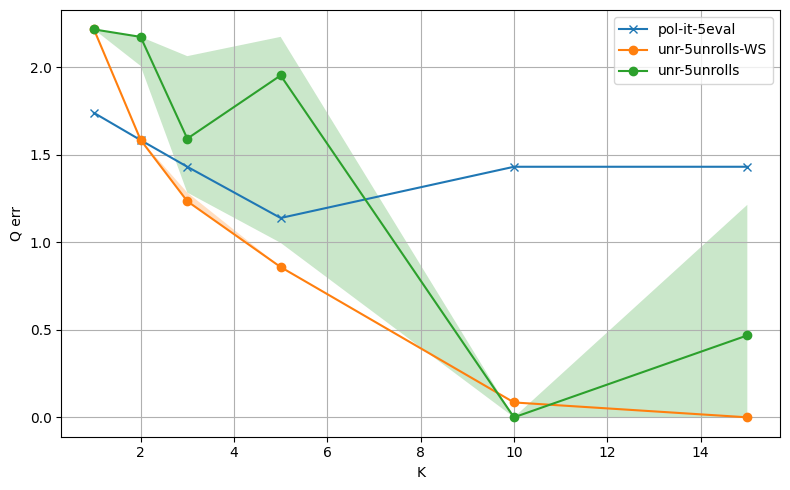

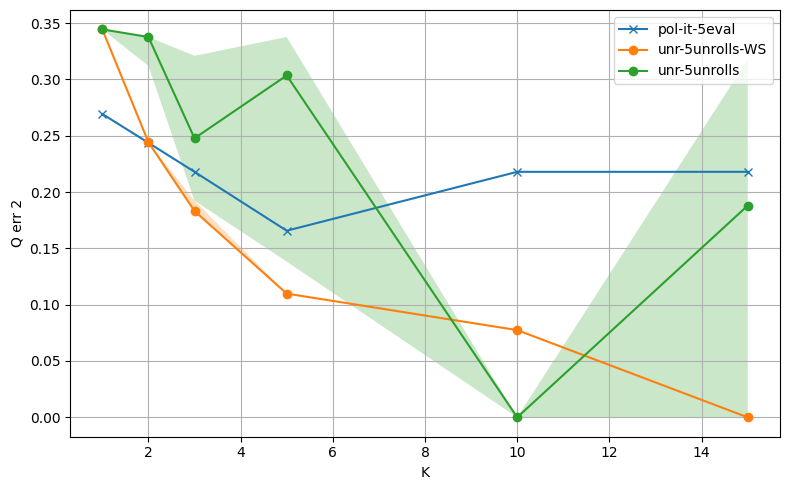

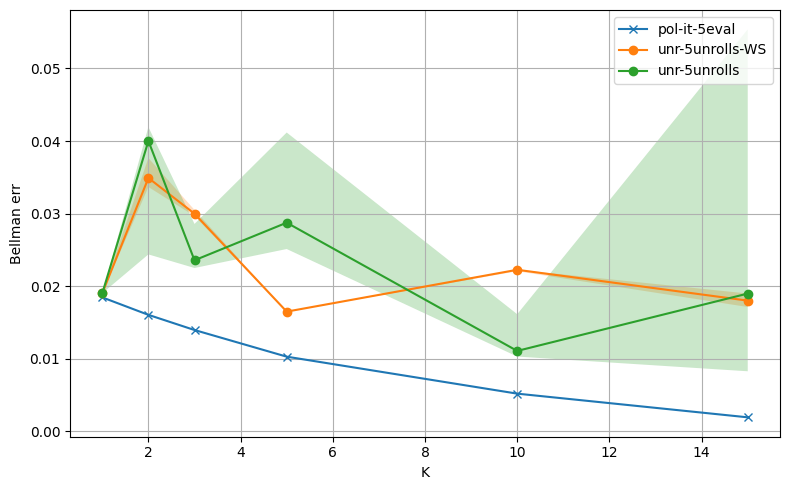

In [12]:
skip_idx = []
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Unrolls = 10

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
num_unrolls = 10
group_name = f"filter_order-{num_unrolls}"

Ks = np.array([1, 2, 3, 5, 10, 15]) # np.arange(1,30, 2)
Exps = [
    {"model": "pol-it", "args": {"max_epochs": num_unrolls}, "fmt": "x-", "name": f"pol-it-{num_unrolls}eval"},

    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls-WS"},
    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls"},

    # {"model": "unroll", "args": {"num_unrolls": 5, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-5unrolls"},
    # {"model": "unroll", "args": {"num_unrolls": 10, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-10unrolls"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

In [ ]:
n_runs = 5

errs1 = np.zeros((n_runs, len(Exps), Ks.size))
errs2 = np.zeros((n_runs, len(Exps), Ks.size))
bell_errs = np.zeros((n_runs, len(Exps), Ks.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, Ks, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, Ks=Ks, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

Data saved as: results/filter_order/filter_order-10_data.npz


In [ ]:
# # Load data
# data = np.load(PATH + "filter_order-10_data.npz", allow_pickle=True)
# Ks = data["Ks"]
# Exps = data["Exps"]
# errs1 = data["errs1"] 
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

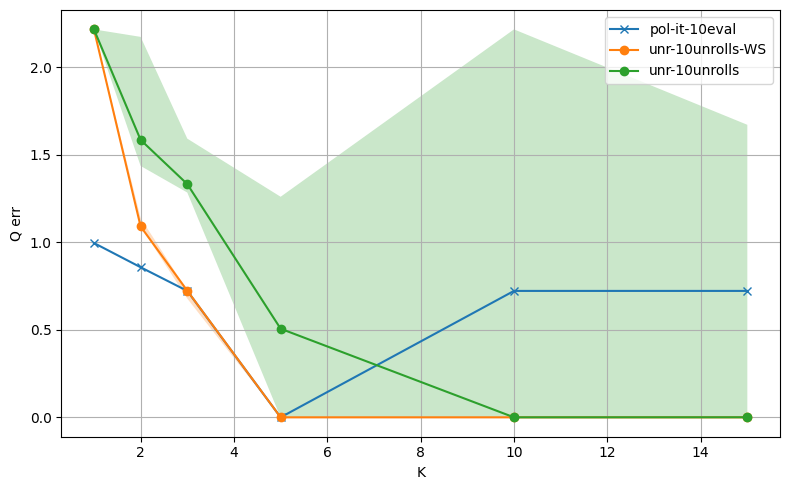

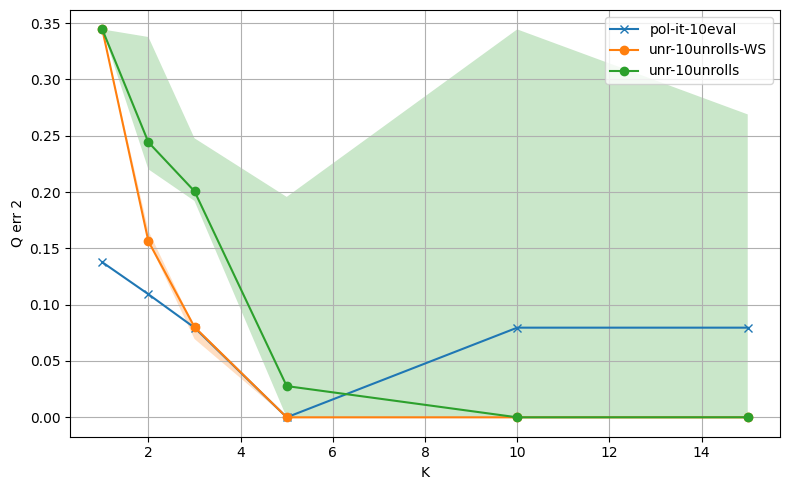

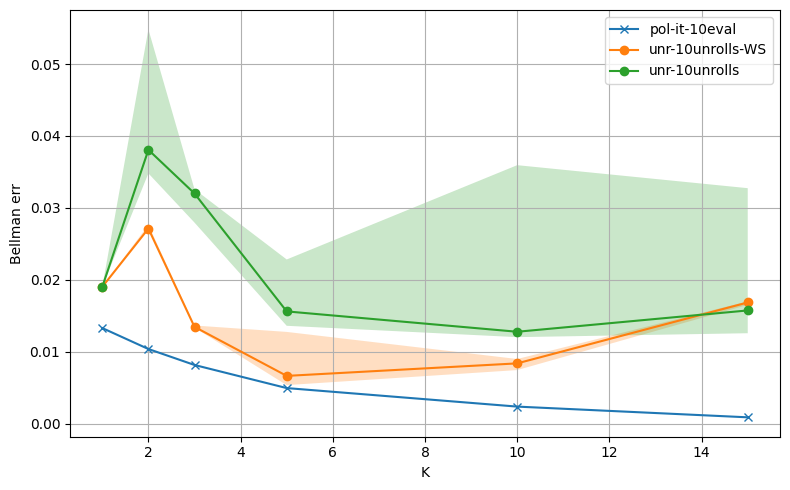

In [20]:
skip_idx = []
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Unrolls = 15

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
num_unrolls = 15
group_name = f"filter_order-{num_unrolls}"

Ks = np.array([1, 2, 3, 5, 10, 15]) # np.arange(1,30, 2)
Exps = [
    {"model": "pol-it", "args": {"max_epochs": num_unrolls}, "fmt": "x-", "name": f"pol-it-{num_unrolls}eval"},

    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls-WS"},
    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls"},

    # {"model": "unroll", "args": {"num_unrolls": 5, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-5unrolls"},
    # {"model": "unroll", "args": {"num_unrolls": 10, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-10unrolls"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

In [ ]:
n_runs = 5

errs1 = np.zeros((n_runs, len(Exps), Ks.size))
errs2 = np.zeros((n_runs, len(Exps), Ks.size))
bell_errs = np.zeros((n_runs, len(Exps), Ks.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, Ks, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, Ks=Ks, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

Data saved as: results/filter_order/filter_order-15_data.npz


In [ ]:
# # Load data
# data = np.load(PATH + "filter_order-15_data.npz", allow_pickle=True)
# Ks = data["Ks"]
# Exps = data["Exps"]
# errs1 = data["errs1"] 
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

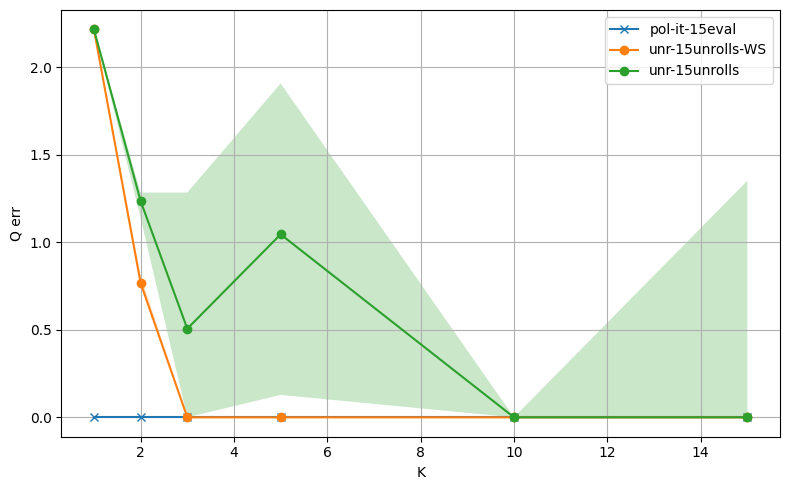

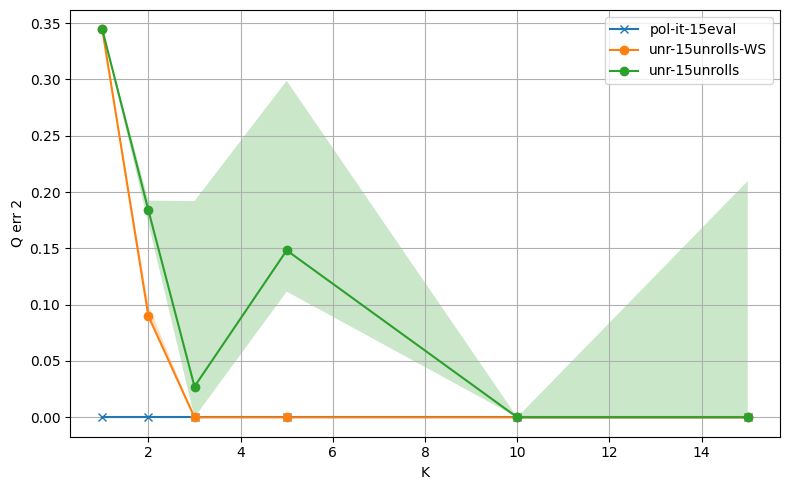

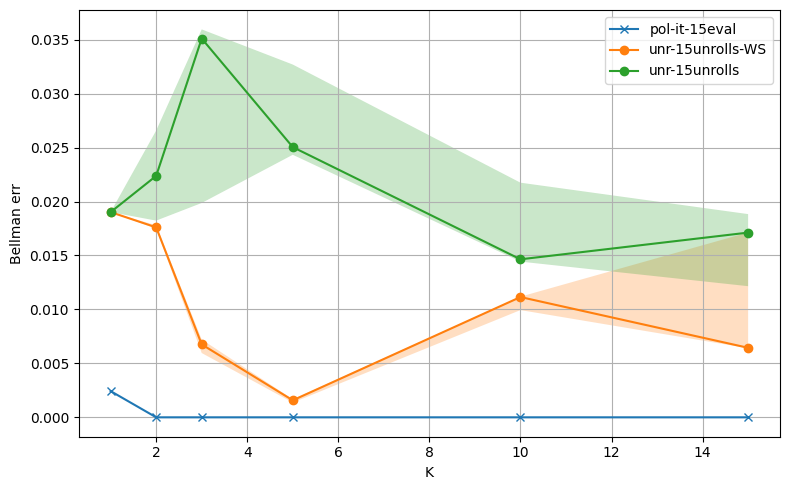

In [26]:
skip_idx = []
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Plot All

In [3]:
# Load data
files = ["filter_order-5_data.npz", "filter_order-10_data.npz", "filter_order-15_data.npz"]

Exps = []
errs1_list = []
errs2_list = []
bell_errs_list = []
for file in files:
    data = np.load(PATH + file, allow_pickle=True)
    
    if 'Ks' not in locals():  # Guardar solo una vez
        Ks = data["Ks"]
    
    Exps += list(data["Exps"])  # Concatenar listas
    
    errs1_list.append(data["errs1"])
    errs2_list.append(data["errs2"])
    bell_errs_list.append(data["bell_errs"])

# Concatenar por la dimensión 1
errs1 = np.concatenate(errs1_list, axis=1)
errs2 = np.concatenate(errs2_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

## Policy iteration vs Unrolling with/withou WS (only 5 and 10 unrolls) 

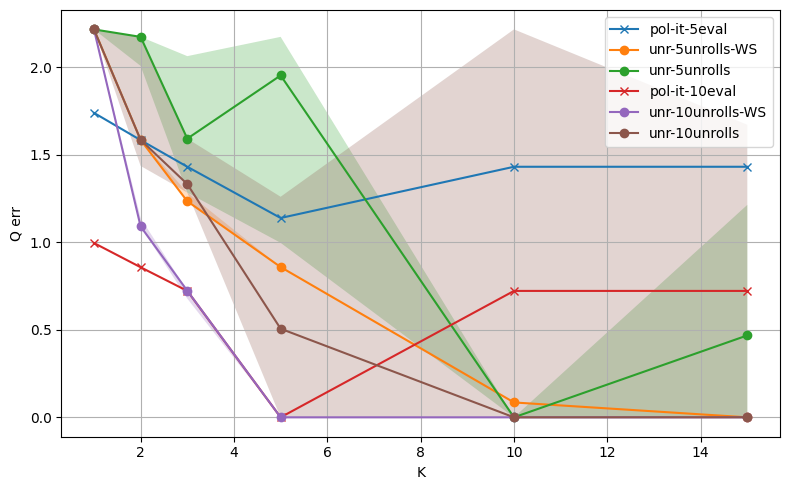

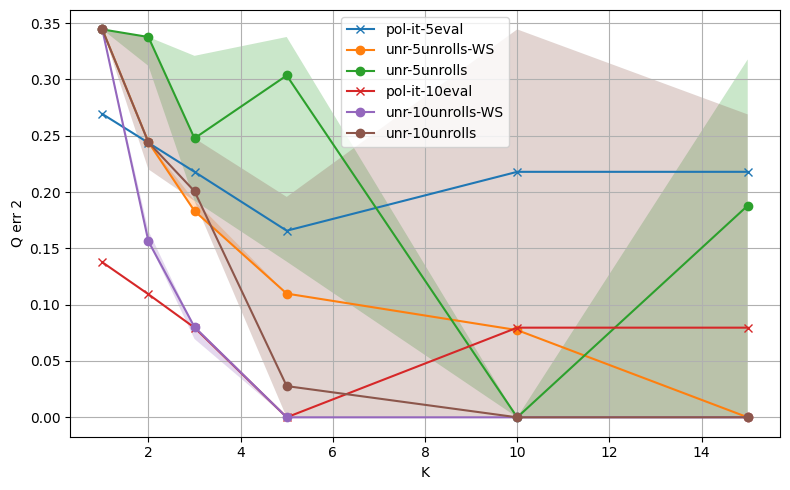

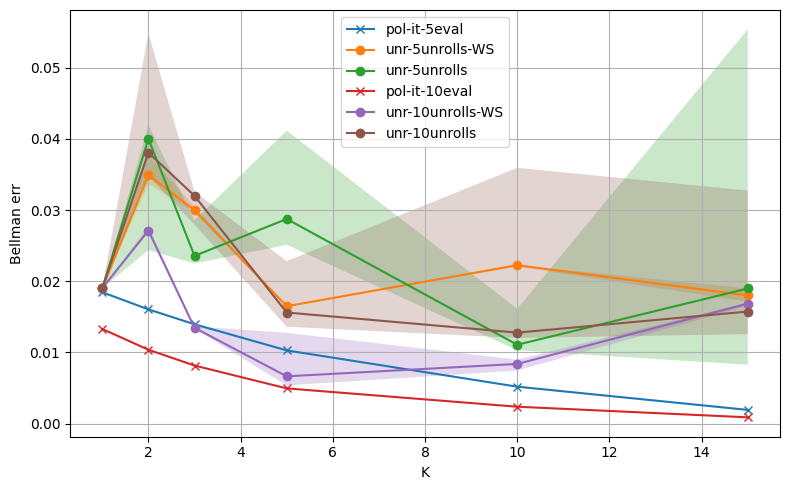

Data saved to csv file: results/filter_order/K_5_10_unr_all_data_med_err.csv
Data saved to csv file: results/filter_order/K_5_10_unr_all_data_prctile25.csv
Data saved to csv file: results/filter_order/K_5_10_unr_all_data_prctile75.csv


In [ ]:
skip_idx = [6, 7, 8]
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')

if SAVE:
    file_name = PATH + "K_5_10_unr_all_data_med_err.csv"
    save_error_matrix_to_csv(np.median(errs2, axis=0), Ks, Exps, file_name)
    file_name = PATH + "K_5_10_unr_all_data_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 25, axis=0), Ks, Exps, file_name)
    file_name = PATH + "K_5_10_unr_all_data_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 75, axis=0), Ks, Exps, file_name)

## Policy iteration vs Unrolling with WS

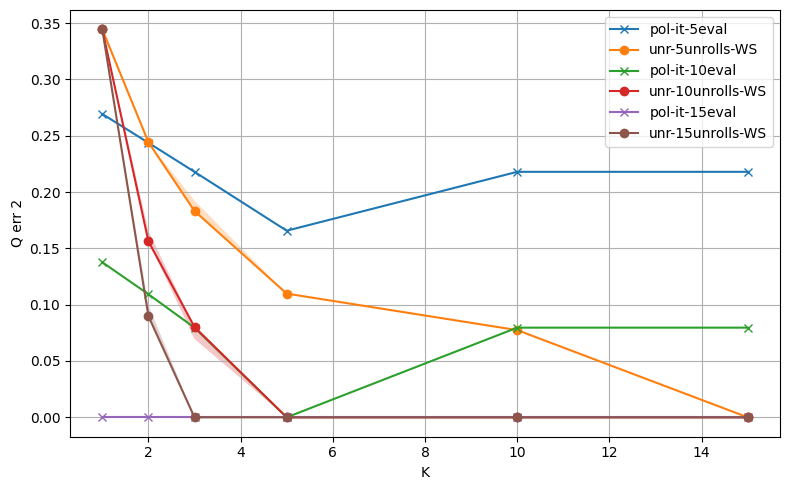

Data saved to csv file: results/filter_order/K_pol_vs_ws_all_data_med_err.csv
Data saved to csv file: results/filter_order/K_pol_vs_ws_unr_all_data_prctile25.csv
Data saved to csv file: results/filter_order/K_pol_vs_ws_all_data_prctile75.csv


In [ ]:
skip_idx = [2, 5, 8]
xlabel = "K"
# plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
# plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')

if SAVE:
    file_name = PATH + "K_pol_vs_ws_all_data_med_err.csv"
    save_error_matrix_to_csv(np.median(errs2, axis=0), Ks, Exps, file_name)
    file_name = PATH + "K_pol_vs_ws_unr_all_data_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 25, axis=0), Ks, Exps, file_name)
    file_name = PATH + "K_pol_vs_ws_all_data_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 75, axis=0), Ks, Exps, file_name)

## Policy iteration vs Unrolling with WS

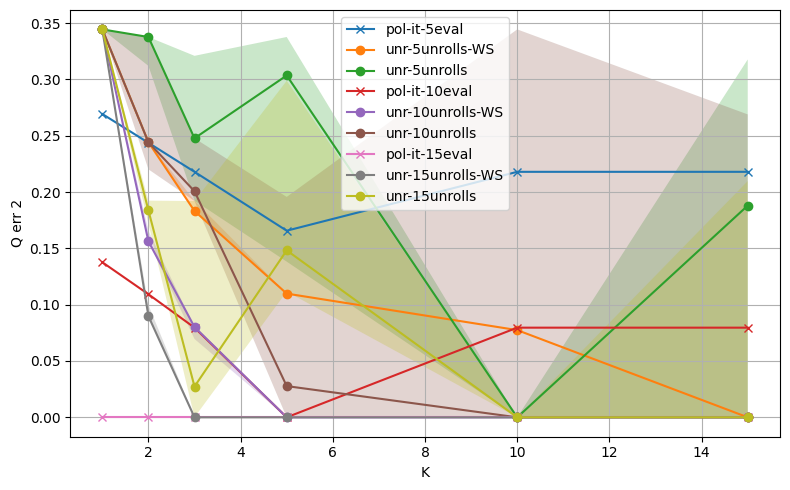

In [40]:
skip_idx = []
xlabel = "K"
# plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
# plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')